### This notebook implements a simple FVM scheme to solve 2D Poisson's equation

The code is not fully optimized. It only serves to examplify concepts in lecture notes.

In [1]:
import numpy as np
import meshpy.triangle as triangle
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

from chp06_utils import *

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

from numpy.linalg import norm
from numpy import dot

In [2]:
min_angle = 30
# Define corners of the rectangle
bc_points = np.array([[0, 0], [1, 0], [1, 1], [0, 1]])
# edges between points
segments = np.array([[0, 1], [1, 2], [2, 3], [3, 0]])

mesh = generate_mesh(bc_points, segments, max_volume=0.01, min_angle=min_angle)
vertices, triangles = extract_mesh_data(mesh)

# Define the source term in the Poisson's equation
f = lambda x : -(2 + x[1]**2)
# we specify the exact u in order to test our results
ref_u = lambda x : x[0]**2 + x[1]**4/12

In [3]:
def list_of_centroid(vertices, triangles):
    """
        Given vertices and triangular regions,
        Return the centroid of each triangles.
    """
    
    N = np.size(triangles,0) # number of triangles
    c = np.zeros((N,2))
    for j in range(N):
        idx_list = triangles[j]
        for vertex_id in idx_list:
            c[j,:] += vertices[vertex_id]
        c[j,:] /= 3
    return c

def find_nearby_triangles(vertex_idx, triangles):
    """
        given a vertex,
        find all triangles that it belongs to.
    """
    L = []
    num_of_triangles = np.size(triangles,0)
    for j in range(num_of_triangles):
        if vertex_idx in triangles[j,:]:
            L.append(j)
    return L

def find_triangles_for_edge(vertex_idx_1, vertex_idx_2, triangles):
    """
        given an edge specified by vertex_id_1 and vertex_id_2,
        find all triangles that it belongs to.
    """
    L = []
    num_of_triangles = np.size(triangles,0)
    for j in range(num_of_triangles):
        if vertex_idx_1 in triangles[j,:] and vertex_idx_2 in triangles[j,:]:
            L.append(j)
    return L

def check_rotation_clock(pts):
    """
        check whether three pts is listed in clockwise or counter-clockwise rotations.
    """
    v1 = pts[1] - pts[0]
    v2 = pts[2] - pts[1]
    if v1[0]*v2[1] - v1[1]*v2[0] >= 0:
        shift_idx = 1
    else:
        shift_idx = -1
    return shift_idx

def compute_perpendicular(pt_a, pt_b, pt_P):
    """
        for the line semgnets pt_a, pt_b, 
        find the foot of perpendicular from the pt_P
    """
    xa = pt_a[0]
    ya = pt_a[1]
    xb = pt_b[0]
    yb = pt_b[1]
    xp = pt_P[0]
    yp = pt_P[1]
    γ = (xa**2+xb*xp-xa*(xb+xp)+(ya-yb)*(ya-yp))/(xa**2 - 2*xa*xb+xb**2 + (ya-yb)**2)
    foot = pt_a + γ * (pt_b - pt_a)
    d = norm(foot - pt_P, 2)
    return foot, d

def FVM_triangular(vertices, triangles, f, verbose=False):
    n = np.size(triangles,0)
    A = np.zeros((n,n))
    b = np.zeros(n)
    
    num_of_vertices = np.size(vertices,0)
    num_of_triangles = np.size(triangles,0)
    centroid = list_of_centroid(vertices, triangles)
    
    for j in range(num_of_triangles):
        tri = triangles[j]
        pts = vertices[tri]
        area = area_of_triangle(pts)
        
        # check if the oritation is clockwise or counter clockwise.
        shift_idx = check_rotation_clock(pts)
        pt_P = centroid[j] # the point P.
        
        # update volume integral
        b[j] += f(pt_P)*area
        
        # we need to work on three line integrals
        for i in range(3):
            pt_a = pts[i]
            pt_b = pts[(i+shift_idx)%3]
            dη = norm(pt_b - pt_a, 2)
            
            # if ths line semgnet is on the boundary
            if check_bc(pt_a, bc_points, segments) and check_bc(pt_b, bc_points, segments):
                foot, d = compute_perpendicular(pt_a, pt_b, pt_P)
                b[j] += ref_u(foot)*dη/d
                A[j,j] += -dη/d

            else:
                l = find_triangles_for_edge(tri[i], tri[(i+shift_idx)%3], triangles)
                l.remove(j)
                pA_idx = l[0]
                pA = centroid[pA_idx,:]
               
                Δx = pt_b[0] - pt_a[0]
                Δy = pt_b[1] - pt_a[1]
                n = np.array([Δy/dη, -Δx/dη])
                eη = np.array([Δx/dη, Δy/dη])
                
                eξ = pA - pt_P
                dξ = norm(eξ,2)
                eξ /= dξ
                
                # direct gradient term
                A[j,j] -= dη/dξ/dot(n, eξ)
                A[j,pA_idx] += dη/dξ/dot(n, eξ)
                
                # update ϕb and ϕa inside the cross-diffusion terms
                c = -dη * dot(eξ, eη)/dη/ dot(n, eξ)
                idx_pt_a = tri[i]
                idx_pt_b = tri[(i+shift_idx)%3]
                # find neighbors of b.
                list_of_neighbor_b = find_nearby_triangles(idx_pt_b, triangles)
                num_neighbor_b = len(list_of_neighbor_b)
                for k in list_of_neighbor_b:
                    A[j,k] += c/num_neighbor_b
                # find neighbors of a.
                list_of_neighbor_a = find_nearby_triangles(idx_pt_a, triangles)
                num_neighbor_a = len(list_of_neighbor_a)
                for k in list_of_neighbor_a:
                    A[j,k] += -c/num_neighbor_a
                    
    # we will solve A ϕ + b = 0.
    u = np.linalg.solve(A, -b)
    print("Condition number in FVM is {:.2E}".format(np.linalg.cond(A)))
    
    return u, centroid

Condition number in FVM is 1.24E+02


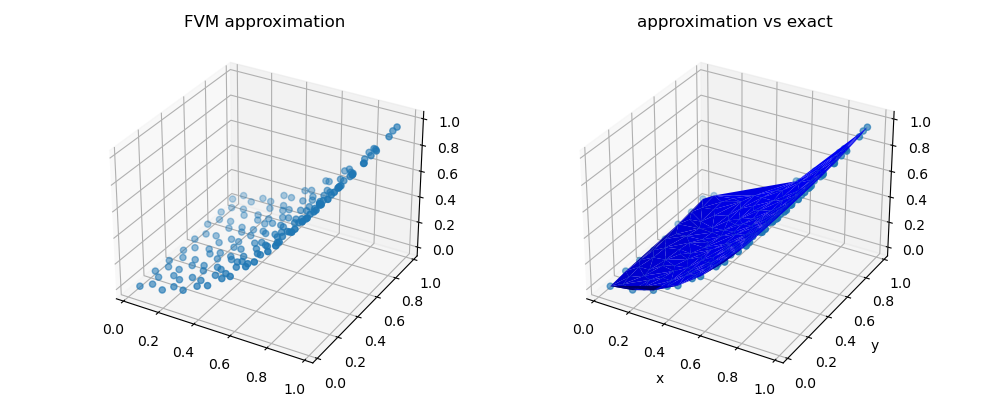

In [4]:
num_of_vertices = np.size(vertices,0)
num_of_triangles = np.size(triangles,0)
centroid = list_of_centroid(vertices, triangles)

u_fvm, centroid = FVM_triangular(vertices, triangles, f)

exact_u_on_centroid = [ref_u(centroid[j,:]) for j in range(num_of_triangles)]

fig = plt.figure(figsize=(10,4))
centroid_x = centroid[:,0]
centroid_y = centroid[:,1]
ax = fig.add_subplot(121, projection='3d')
ax.scatter(centroid_x, centroid_y, u_fvm)
ax.set_title('FVM approximation')

ax = fig.add_subplot(122, projection='3d')
ax.scatter(centroid_x, centroid_y, u_fvm)
ax.plot_trisurf(centroid_x, centroid_y, exact_u_on_centroid, color='b')
ax.set_xlabel('x'); ax.set_ylabel('y')
ax.set_title('approximation vs exact')

plt.tight_layout()
plt.show()

In [5]:
err_fvm = norm(exact_u_on_centroid - u_fvm)
print("Error of FVM is {:.2E}".format(err_fvm))

list_of_area = np.zeros(len(triangles))
for j in range(num_of_triangles):
    pts = vertices[triangles[j]]
    list_of_area = area_of_triangle(pts)
    
err_fvm_l2 = np.sqrt(np.sum((exact_u_on_centroid - u_fvm)**2*list_of_area))
print("L2 Error of FVM is approximately {:.2E}".format(err_fvm_l2))

Error of FVM is 4.19E-02
L2 Error of FVM is approximately 3.07E-03
